In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


from itertools import combinations
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
from statsmodels.stats.weightstats import ztest,ttest_ind
np.random.seed(42)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Carregando dados
>Fonte: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016

> Fonte IDH: http://hdr.undp.org/en/indicators/137506#

**Sobre este arquivo**: 
country, year, sex, age group, count of suicides, population, suicide rate, country-year composite key, HDI for year, gdpforyear, gdppercapita, generation (based on age grouping average).

In [ ]:
diretorio = '/content/drive/MyDrive/Colab Notebooks/Projetos Autonomos/Estátistica/Suicídio/master.csv'
df = pd.read_csv(diretorio)

print('Amostras: %i' % (len(df)))
df.head()

Amostras: 27820


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


HDI: IDH // GDP: PIB

In [ ]:
df.columns = ['pais','ano','sexo','idade_do_grupo','num_suicidios','populacao','suicidios/100k pop','pais_ano','IDH_por_ano','PIB_por_ano',
              'PIB_per_capita','geracao']
df.head()

,pais,ano,sexo,idade_do_grupo,num_suicidios,populacao,suicidios/100k pop,pais_ano,IDH_por_ano,PIB_por_ano,PIB_per_capita,geracao
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [ ]:
(df.isna().sum() / len(df)) * 100 # PORCENTAGEM DE NAN's
# 70% dos dados não possuem IDH, não droparei

pais                   0.000000
ano                    0.000000
sexo                   0.000000
idade_do_grupo         0.000000
num_suicidios          0.000000
populacao              0.000000
suicidios/100k pop     0.000000
pais_ano               0.000000
IDH_por_ano           69.935298
PIB_por_ano            0.000000
PIB_per_capita         0.000000
geracao                0.000000
dtype: float64

***Carregando IDH's***

In [ ]:
diretorio2 = '/content/drive/MyDrive/Colab Notebooks/Projetos Autonomos/Estátistica/Suicídio/idhs.csv'
idh = pd.read_csv(diretorio2, encoding = 'latin-1')

idh.head()

,HDI Rank,Country,1990,Unnamed: 3,1991,Unnamed: 5,1992,Unnamed: 7,1993,Unnamed: 9,1994,Unnamed: 11,1995,Unnamed: 13,1996,Unnamed: 15,1997,Unnamed: 17,1998,Unnamed: 19,1999,Unnamed: 21,2000,Unnamed: 23,2001,Unnamed: 25,2002,Unnamed: 27,2003,Unnamed: 29,2004,Unnamed: 31,2005,Unnamed: 33,2006,Unnamed: 35,2007,Unnamed: 37,2008,Unnamed: 39,2009,Unnamed: 41,2010,Unnamed: 43,2011,Unnamed: 45,2012,Unnamed: 47,2013,Unnamed: 49,2014,Unnamed: 51,2015,Unnamed: 53,2016,Unnamed: 55,2017,Unnamed: 57,2018,Unnamed: 59,2019,Unnamed: 61
0,169,Afghanistan,0.302,NaN,0.307,NaN,0.316,NaN,0.312,NaN,0.307,NaN,0.331,NaN,0.335,NaN,0.339,NaN,0.344,NaN,0.348,NaN,0.350,NaN,0.353,NaN,0.384,NaN,0.393,NaN,0.409,NaN,0.418,NaN,0.429,NaN,0.447,NaN,0.447,NaN,0.460,NaN,0.472,NaN,0.477,NaN,0.489,NaN,0.496,NaN,0.500,NaN,0.500,NaN,0.502,NaN,0.506,NaN,0.509,NaN,0.511,NaN
1,69,Albania,0.650,NaN,0.631,NaN,0.615,NaN,0.618,NaN,0.624,NaN,0.637,NaN,0.646,NaN,0.645,NaN,0.655,NaN,0.665,NaN,0.671,NaN,0.678,NaN,0.684,NaN,0.691,NaN,0.696,NaN,0.706,NaN,0.713,NaN,0.722,NaN,0.728,NaN,0.733,NaN,0.745,NaN,0.764,NaN,0.775,NaN,0.782,NaN,0.787,NaN,0.788,NaN,0.788,NaN,0.790,NaN,0.792,NaN,0.795,NaN
2,91,Algeria,0.572,NaN,0.576,NaN,0.582,NaN,0.586,NaN,0.590,NaN,0.595,NaN,0.602,NaN,0.611,NaN,0.621,NaN,0.629,NaN,0.637,NaN,0.647,NaN,0.657,NaN,0.667,NaN,0.677,NaN,0.685,NaN,0.690,NaN,0.700,NaN,0.702,NaN,0.711,NaN,0.721,NaN,0.728,NaN,0.728,NaN,0.729,NaN,0.736,NaN,0.740,NaN,0.743,NaN,0.745,NaN,0.746,NaN,0.748,NaN
3,36,Andorra,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.813,NaN,0.815,NaN,0.820,NaN,0.827,NaN,0.833,NaN,0.827,NaN,0.837,NaN,0.837,NaN,0.840,NaN,0.839,NaN,0.837,NaN,0.836,NaN,0.858,NaN,0.856,NaN,0.863,NaN,0.862,NaN,0.866,NaN,0.863,NaN,0.867,NaN,0.868,NaN
4,148,Angola,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.391,NaN,0.400,NaN,0.410,NaN,0.426,NaN,0.435,NaN,0.446,NaN,0.460,NaN,0.473,NaN,0.489,NaN,0.501,NaN,0.515,NaN,0.517,NaN,0.533,NaN,0.544,NaN,0.555,NaN,0.565,NaN,0.572,NaN,0.578,NaN,0.582,NaN,0.582,NaN,0.581,NaN


In [ ]:
idh.drop(columns = ['Unnamed: %s' % i for i in range(3,62,2)],inplace=True)
idh.replace({'..':np.nan}, inplace = True)
idh.head()

,HDI Rank,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,169,Afghanistan,0.302,0.307,0.316,0.312,0.307,0.331,0.335,0.339,0.344,0.348,0.350,0.353,0.384,0.393,0.409,0.418,0.429,0.447,0.447,0.460,0.472,0.477,0.489,0.496,0.500,0.500,0.502,0.506,0.509,0.511
1,69,Albania,0.650,0.631,0.615,0.618,0.624,0.637,0.646,0.645,0.655,0.665,0.671,0.678,0.684,0.691,0.696,0.706,0.713,0.722,0.728,0.733,0.745,0.764,0.775,0.782,0.787,0.788,0.788,0.790,0.792,0.795
2,91,Algeria,0.572,0.576,0.582,0.586,0.590,0.595,0.602,0.611,0.621,0.629,0.637,0.647,0.657,0.667,0.677,0.685,0.690,0.700,0.702,0.711,0.721,0.728,0.728,0.729,0.736,0.740,0.743,0.745,0.746,0.748
3,36,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813,0.815,0.820,0.827,0.833,0.827,0.837,0.837,0.840,0.839,0.837,0.836,0.858,0.856,0.863,0.862,0.866,0.863,0.867,0.868
4,148,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.391,0.400,0.410,0.426,0.435,0.446,0.460,0.473,0.489,0.501,0.515,0.517,0.533,0.544,0.555,0.565,0.572,0.578,0.582,0.582,0.581


In [ ]:
Country = list()
for i in idh.Country.values:

  if type(i) == type('str'):
    Country.append(i.strip())
  else:
    Country.append(i)

idh['Country'] = Country

# Análises
* **Análise estátistica** : Gráfica e testes de hipóteses

* **Análise Gráfica**: Apenas gráfica

In [ ]:
significancia = 0.05

def verificar_teste(p_valor,significancia = significancia):
  rejeita = p_valor <= significancia

  if rejeita:
    return False # Teste é Falso
  else:
    return True # Teste é Verdadeiro

In [ ]:
df.head()

,pais,ano,sexo,idade_do_grupo,num_suicidios,populacao,suicidios/100k pop,pais_ano,IDH_por_ano,PIB_por_ano,PIB_per_capita,geracao
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


### Primeira Análise
> Pais X Ano - Análise Gráfica

In [ ]:
relacao_pais_ano = df.groupby(['pais_ano']).sum()[['num_suicidios','populacao']]
relacao_pais_ano['suicidios/100k pop'] = (relacao_pais_ano['num_suicidios'] / relacao_pais_ano['populacao']) * 100000
relacao_pais_ano.reset_index(inplace=True)
relacao_pais_ano.head(10)

,pais_ano,num_suicidios,populacao,suicidios/100k pop
0,Albania1987,73,2709600,2.694125
1,Albania1988,63,2764300,2.279058
2,Albania1989,68,2803100,2.425886
3,Albania1992,47,2822500,1.665190
4,Albania1993,73,2807300,2.600363
5,Albania1994,50,2849300,1.754817
6,Albania1995,88,2903400,3.030929
7,Albania1996,89,2940200,3.027005
8,Albania1997,170,2977300,5.709871
9,Albania1998,154,3012700,5.111694


In [ ]:
def relacao_por_pais_ano(pais):
  tamanho = len(pais)
  dataframe = relacao_pais_ano[[True if (pais == i[:tamanho]) else False for i in relacao_pais_ano.pais_ano.values]]
  print('Tamanho das amostras: %i' % len(dataframe))


  return dataframe

In [ ]:
def plot(pais):
  # Criando váriaveis
  a = relacao_por_pais_ano(pais)
  eixo_x = np.array([i[-4:] for i in a['pais_ano']]).astype(np.int32())
  q1,q2,q3 = a['suicidios/100k pop'].quantile([0.3,0.5,0.7]).values

  # Montando separação de cores
  cor1 = a['suicidios/100k pop'].values  <= q1
  cor2 = (a['suicidios/100k pop'].values  > q1) & (a['suicidios/100k pop'].values <= q2)
  cor3 = (a['suicidios/100k pop'].values  > q2) & (a['suicidios/100k pop'].values <= q3)
  cor4 = a['suicidios/100k pop'].values  > q3

  # Gráfico
  figure = plt.figure(figsize = (10,6))
  ax = figure.add_axes([0,0,1,1])

  ### Plot's
  ax.bar(eixo_x[cor1], a['suicidios/100k pop'].values[cor1], edgecolor = 'k', color = 'limegreen', linewidth = 1.2, label = 'Baixa')
  ax.bar(eixo_x[cor2], a['suicidios/100k pop'].values[cor2], edgecolor = 'k', color = 'gold', linewidth = 1.2, label = 'Média')
  ax.bar(eixo_x[cor3], a['suicidios/100k pop'].values[cor3], edgecolor = 'k', color =  'darkorange', linewidth = 1.2, label = 'Alta')
  ax.bar(eixo_x[cor4], a['suicidios/100k pop'].values[cor4], edgecolor = 'k', color = 'r', linewidth = 1.2, label = 'Muito alta')
  ax.grid(True, linestyle = '--', lw = 0.5)

  ### Titulos e legendas
  ax.set_title(f'Suicidio / 100k de população no ano - {pais}', fontsize = 20)
  ax.set_xlabel('Ano', fontsize = 15)
  ax.set_ylabel('Suicidios / 100k de pop', fontsize = 15)
  ax.legend(title = 'Quantidade',title_fontsize = 17, fontsize = 12, edgecolor = 'k', loc = [1.01,0])

Tamanho das amostras: 31


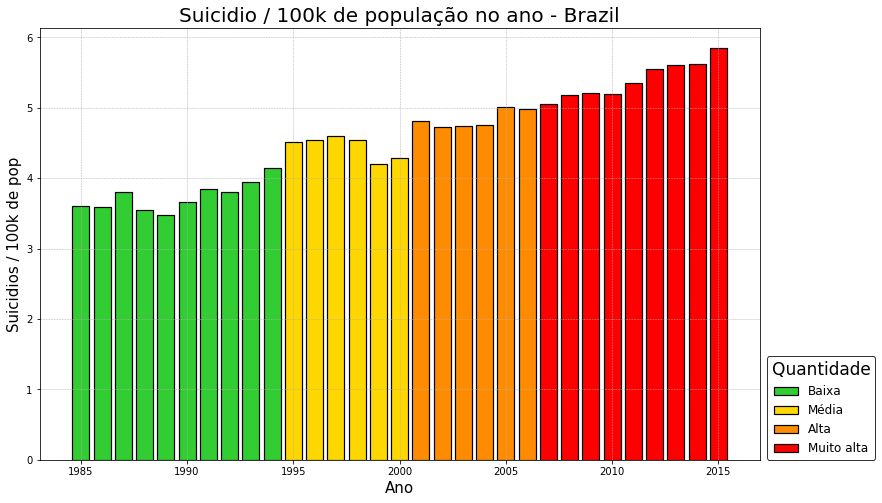

In [ ]:
plot('Brazil')

Tamanho das amostras: 26


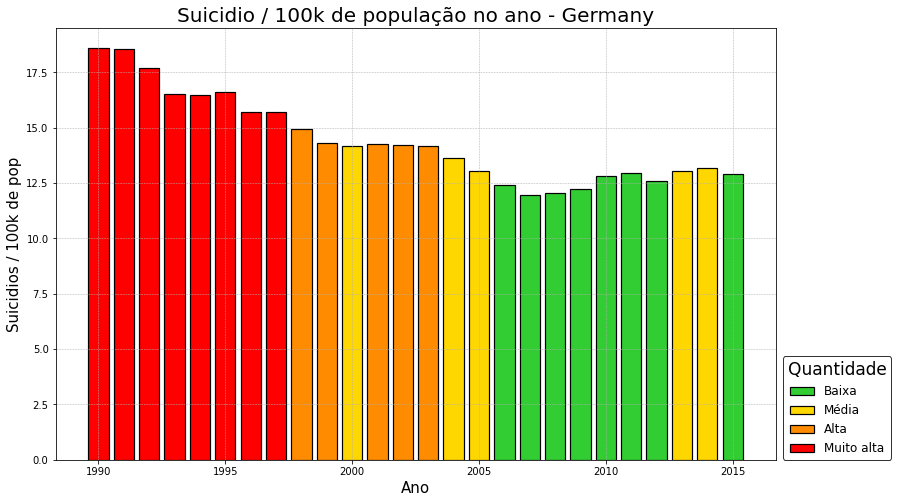

In [ ]:
plot('Germany')

Tamanho das amostras: 30


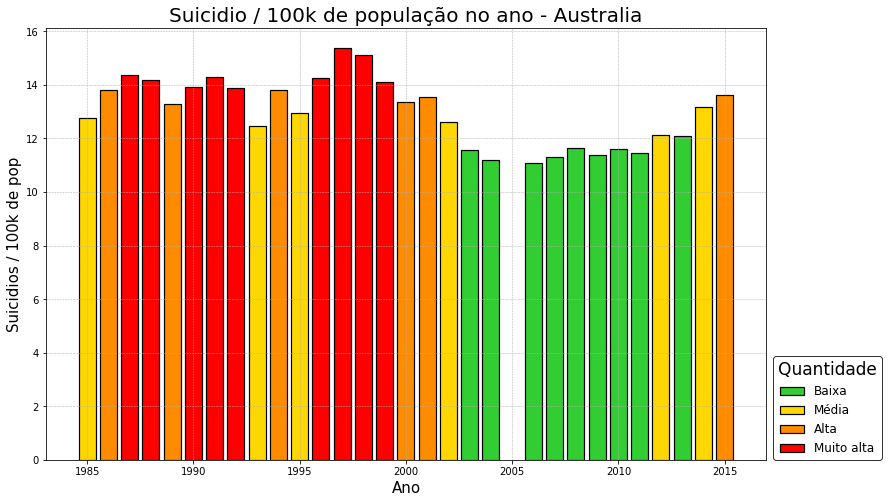

In [ ]:
plot('Australia')

Tamanho das amostras: 31


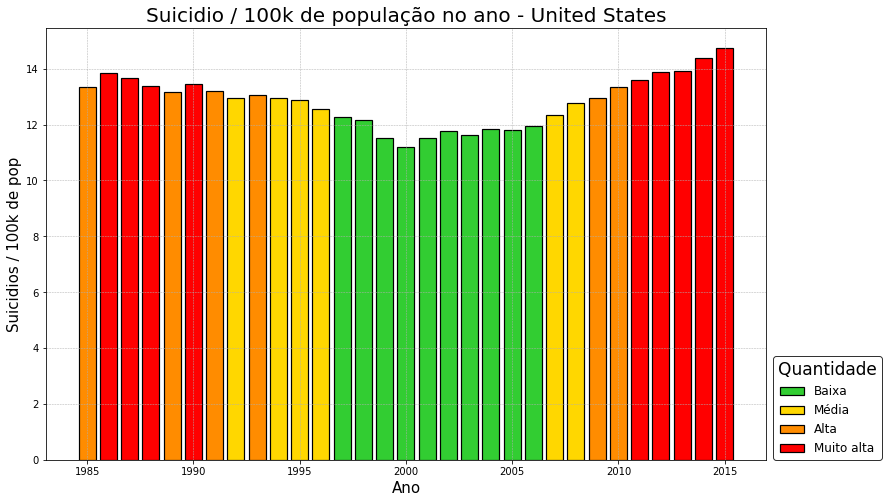

In [ ]:
plot('United States')

Tamanho das amostras: 31


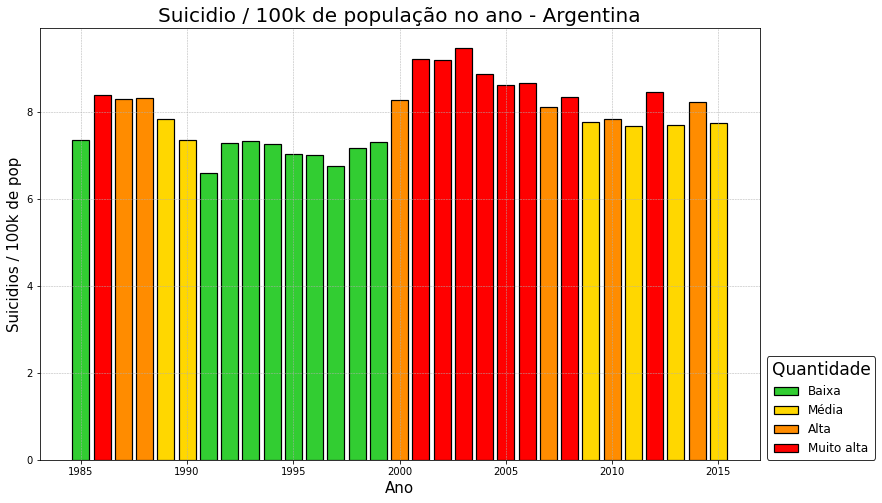

In [ ]:
plot('Argentina')

Tamanho das amostras: 27


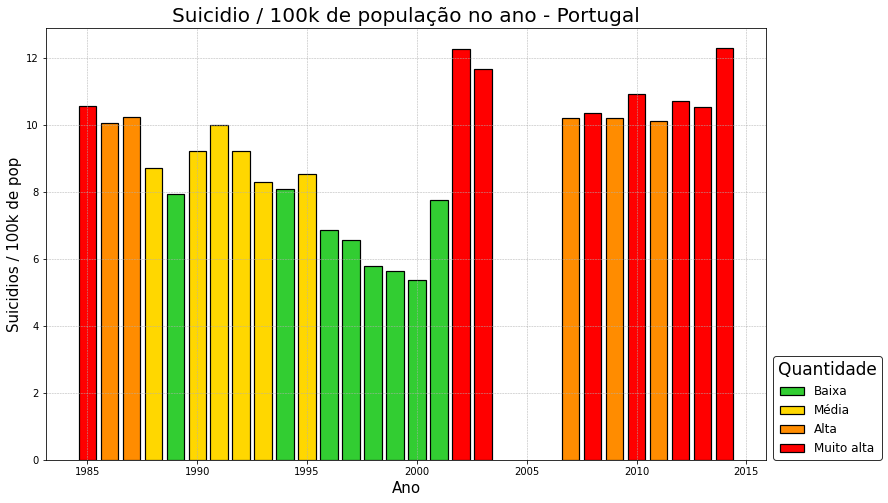

In [ ]:
plot('Portugal')

Tamanho das amostras: 27


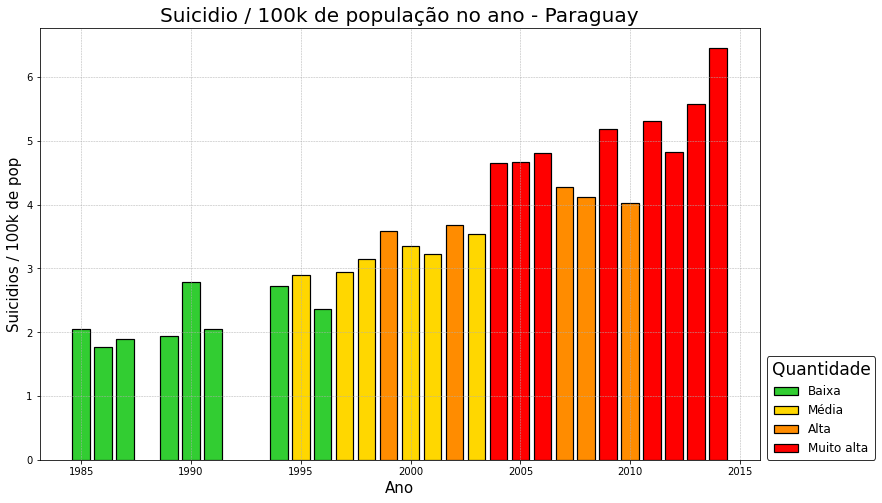

In [ ]:
plot('Paraguay')

Tamanho das amostras: 20


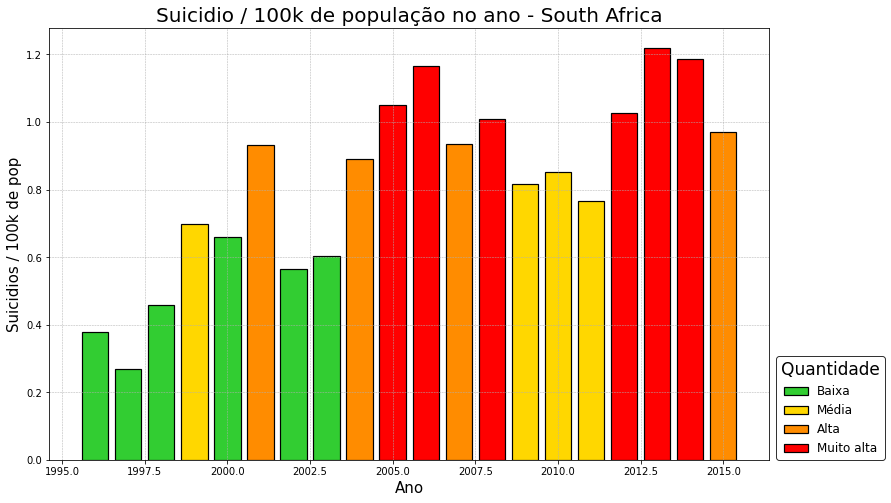

In [ ]:
plot('South Africa')

Tamanho das amostras: 30


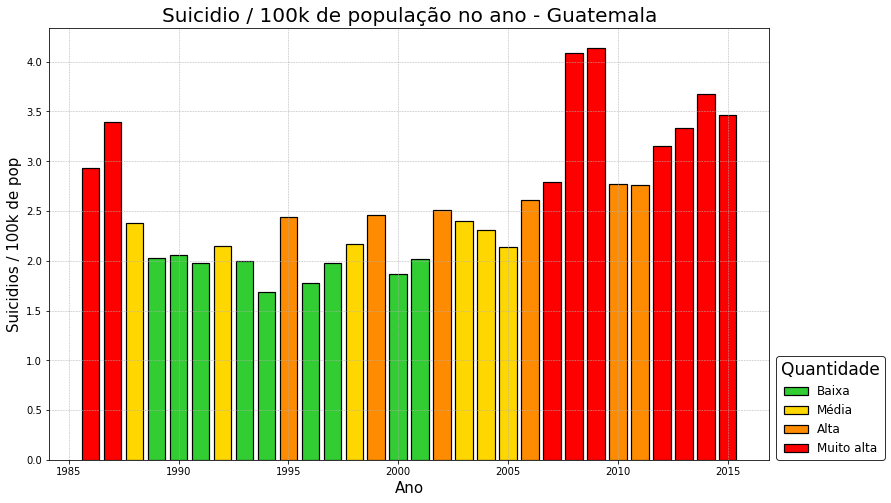

In [ ]:
plot('Guatemala')

Tamanho das amostras: 6


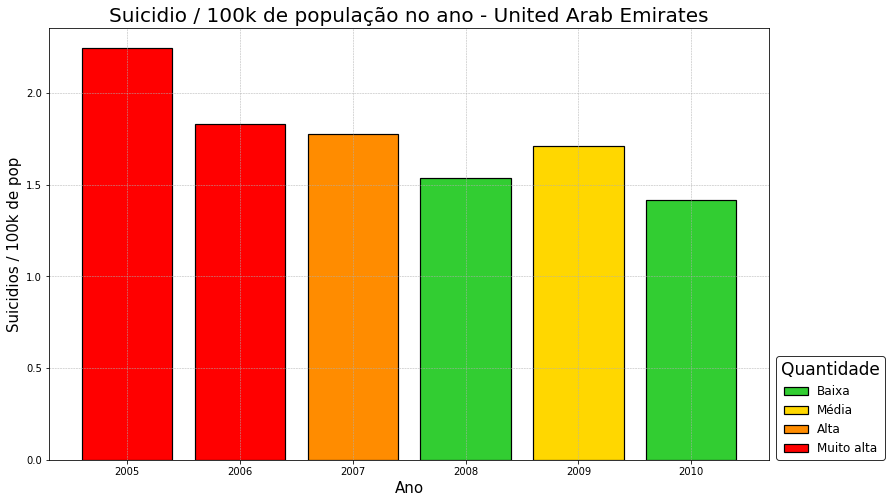

In [ ]:
plot('United Arab Emirates')

Tamanho das amostras: 27


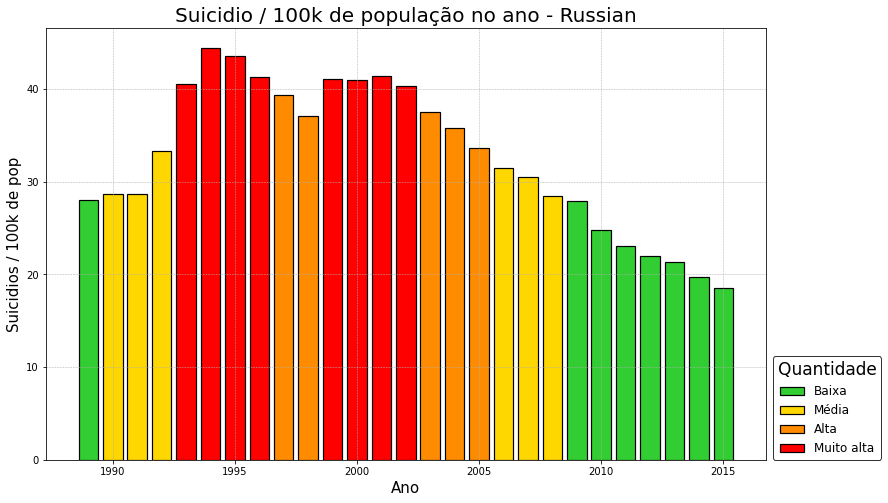

In [ ]:
plot('Russian')

Tamanho das amostras: 31


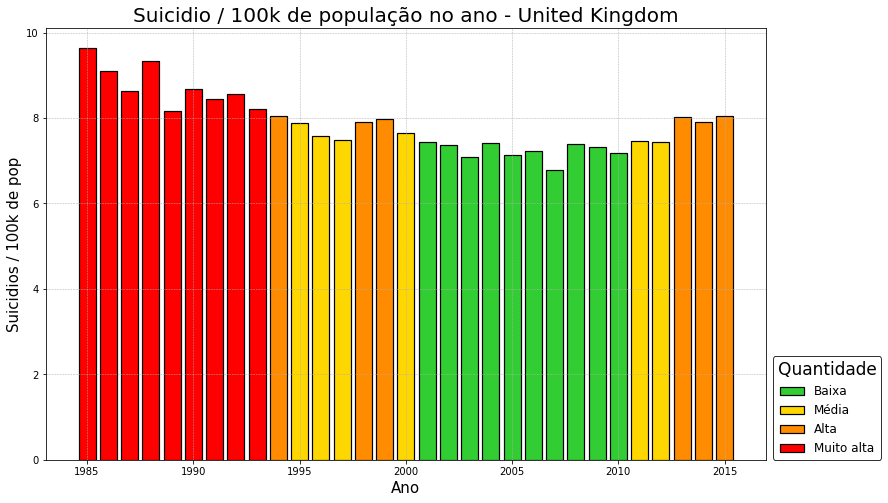

In [ ]:
plot('United Kingdom')

Tamanho das amostras: 22


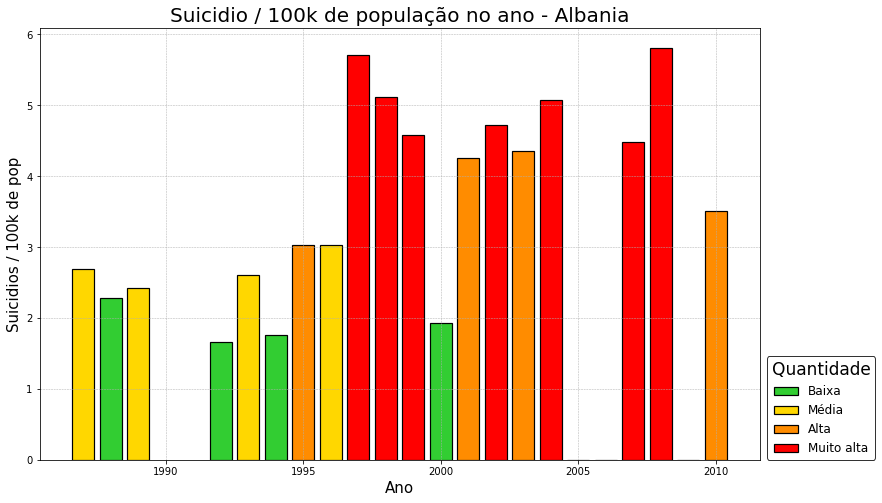

In [ ]:
plot('Albania')

### Segunda Análise
> Ano X Ano - Análise estátistica

#### Gráfico

In [ ]:
df2 = df.groupby('ano').sum()[['num_suicidios','populacao']]
df2.head(10)

,num_suicidios,populacao
ano,,
1985,116063,1008600086
1986,120670,1029909613
1987,126842,1095029726
1988,121026,1054094424
1989,160244,1225514347
1990,193361,1466620100
1991,198020,1489988384
1992,211473,1569539447
1993,221565,1530416654


In [ ]:
df2['suicidios/100k pop'] = (df2['num_suicidios'] / df2['populacao']) * 100000
df2.reset_index(inplace = True)
df2.head()

,ano,num_suicidios,populacao,suicidios/100k pop
0,1985,116063,1008600086,11.507336
1,1986,120670,1029909613,11.716562
2,1987,126842,1095029726,11.583430
3,1988,121026,1054094424,11.481514
4,1989,160244,1225514347,13.075653


Text(0.5, 1.0, 'Suicidios/100k pop por ano')

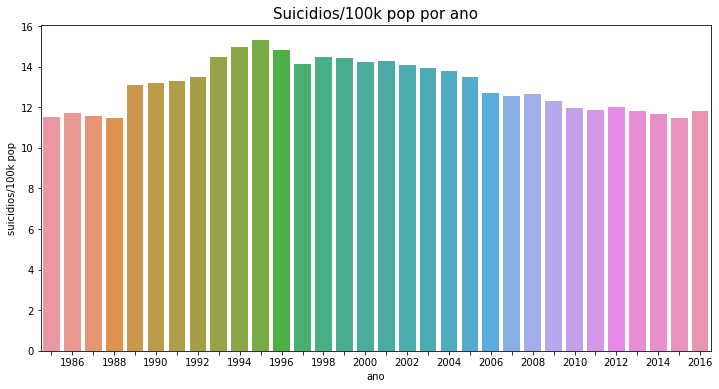

In [ ]:
ax = sns.barplot(x = 'ano', y = 'suicidios/100k pop', data = df2)
ax.figure.set_size_inches(12,6)

# Separar xticks
for label in ax.get_xticklabels():
    if np.int(label.get_text()) % 2 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)

ax.set_title('Suicidios/100k pop por ano', fontsize = 15)

#### Teste Estátistico

In [ ]:
df2.corr()

,ano,num_suicidios,populacao,suicidios/100k pop
ano,1.000000,0.258224,0.411896,-0.268832
num_suicidios,0.258224,1.000000,0.936768,0.564181
populacao,0.411896,0.936768,1.000000,0.242029
suicidios/100k pop,-0.268832,0.564181,0.242029,1.000000


**Para comparar anos entre si, terei que utilizar a base da dados padrão**

In [ ]:
for ano in df.ano.unique():
  stat, p_valor = normaltest(df.query(f'ano == {ano}')['suicidios/100k pop'])
  a = verificar_teste(p_valor)

  if a:
    print(ano)

**A base de dados de suícidio por ano não apresenta uma distribuição normal, tendo que usar testes não-paramétricos**

[(0.0, 50.0)]

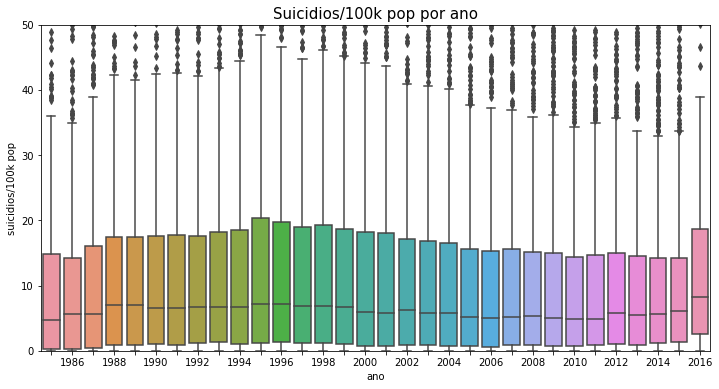

In [ ]:
ax = sns.boxplot(x = 'ano', y = 'suicidios/100k pop', data = df)
ax.figure.set_size_inches(12,6)

# Separar xticks
for label in ax.get_xticklabels():
    if np.int(label.get_text()) % 2 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)

ax.set_title('Suicidios/100k pop por ano', fontsize = 15)
ax.set(ylim = (0,50))

In [ ]:
def plot_ano_vs_ano(ano_1,ano_2):
  anos = [ano_1,ano_2]
  ax = sns.boxplot(x = 'ano',y = 'suicidios/100k pop', data = df.query(f'ano in {anos}'))
  ax.figure.set_size_inches(8,6)
  ax.set(ylim = (0,50))

In [ ]:
def comparar_anos(ano_1, ano_2):
  s1 = df.query(f'ano == {ano_1}')['suicidios/100k pop']
  s2 = df.query(f'ano == {ano_2}')['suicidios/100k pop']
  plot_ano_vs_ano(ano_1 = ano_1,ano_2 = ano_2)

  if len(s1) < len(s2):
    x,y = s1,s2
    x_ano,y_ano = ano_1, ano_2
  else:
    x,y = s2,s1
    x_ano,y_ano = ano_2, ano_1

  u, p_valor = mannwhitneyu(x,y, alternative = 'two-sided')
  teste = verificar_teste(p_valor)

  if teste:
    print('As amostras possuem medidas iguais')

  else:
    u, p_valor = mannwhitneyu(x,y, alternative = 'less') # H0 não terá medidas iguais visto que o teste bicaldal foi recusado acima
    teste = verificar_teste(p_valor)                     # H0: X > Y // H1: X < Y

    if teste:
      print(f'O ano de {x_ano} teve medidas maiores que no ano de {y_ano}')
    else:
      print(f'O ano de {y_ano} teve medidas maiores que no ano de {x_ano}')

As amostras possuem medidas iguais


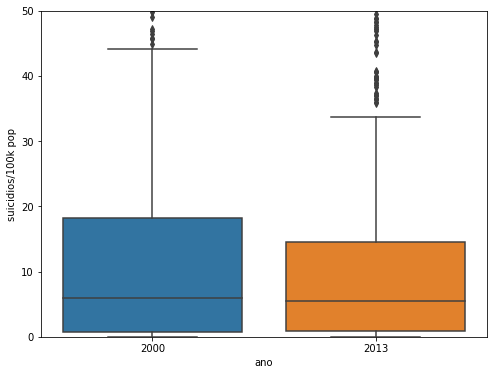

In [ ]:
comparar_anos(ano_1=2013,ano_2=2000)

O ano de 2016 teve medidas maiores que no ano de 2015


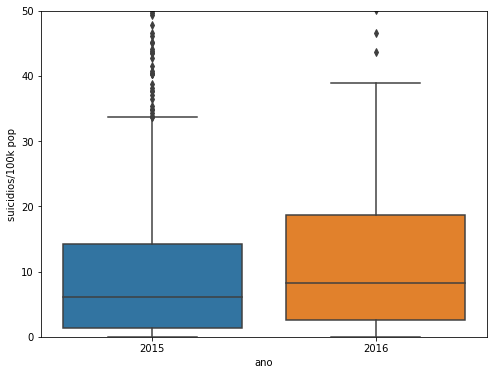

In [ ]:
comparar_anos(ano_1=2015,ano_2=2016)

As amostras possuem medidas iguais


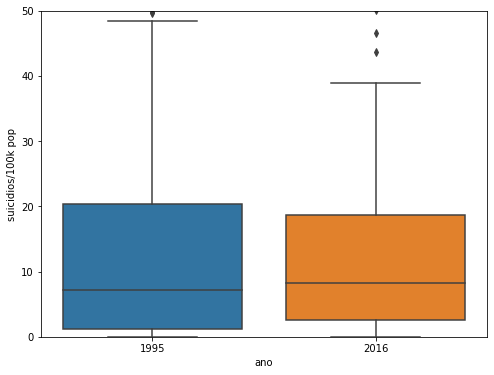

In [ ]:
comparar_anos(1995, 2016)

O ano de 1995 teve medidas maiores que no ano de 2000


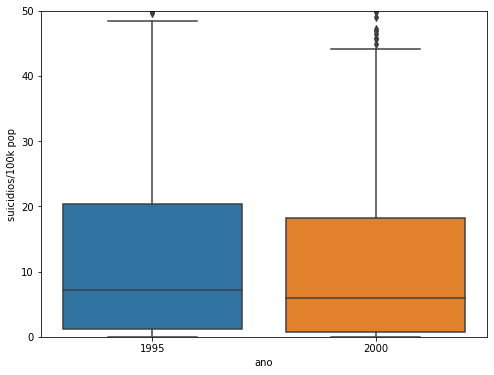

In [ ]:
comparar_anos(1995, 2000)

O ano de 1998 teve medidas maiores que no ano de 2011


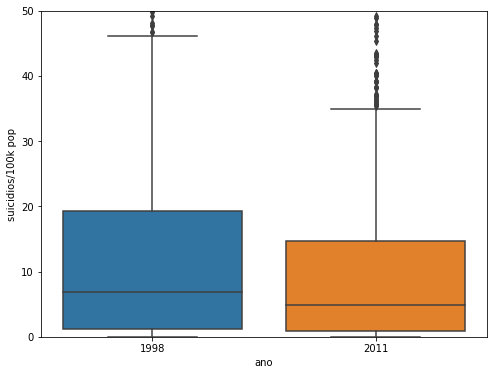

In [ ]:
comparar_anos(1998, 2011)

O ano de 1995 teve medidas maiores que no ano de 1985


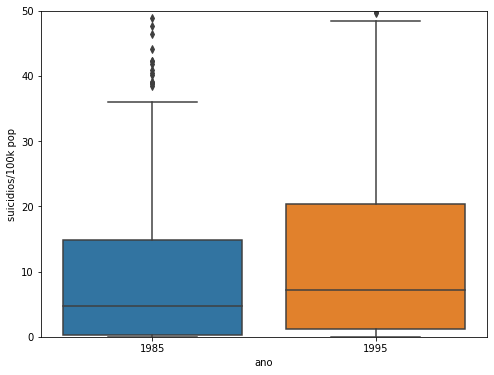

In [ ]:
comparar_anos(1985, 1995)

O ano de 2015 teve medidas maiores que no ano de 1985


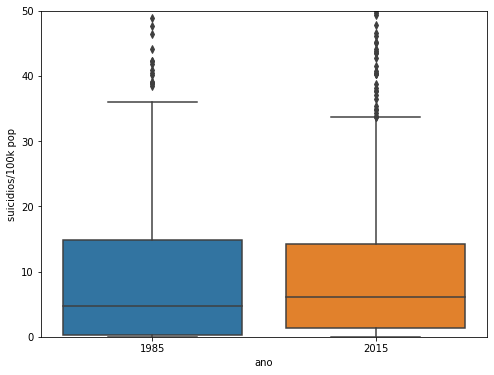

In [ ]:
comparar_anos(1985, 2015)

As amostras possuem medidas iguais


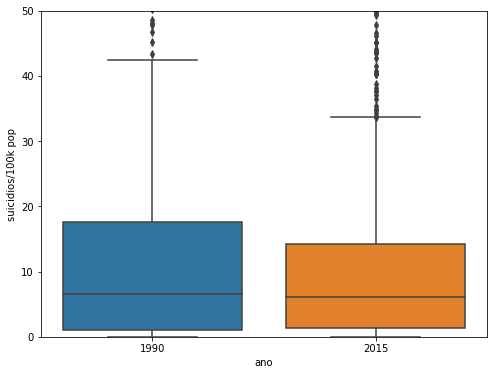

In [ ]:
comparar_anos(1990, 2015)

### Terceira Análise
> País X País - Análise estátistica

**Obs: Não coloquei o fator ano pois não existe amostras o suficiente para tirar uma conclusão plausível sobre em determinado ano**

In [ ]:
# Precisamos de um numero de amostras igua ou maior que 8
paises_a_dropar = [pais for pais in df.pais.unique() if df.query(f'pais == "{pais}"').groupby('ano').sum()[['num_suicidios','populacao']].shape[0] < 8]
df3 = df.query(f'pais not in {paises_a_dropar}')

In [ ]:
hipoteses = list()

for pais in df3.pais.unique():
  s1 = df3.query(f'pais == "{pais}"').groupby('ano').sum()[['num_suicidios','populacao']]
  s1 = (s1['num_suicidios'] / s1['populacao']) * 100000
  if verificar_teste(normaltest(s1)[-1]) == True:
    hipoteses.append('H0')
  else:
    hipoteses.append('H1')

frequencia = pd.value_counts(hipoteses)
porcentagem = (frequencia / len(hipoteses)) * 100

a = pd.DataFrame([frequencia,porcentagem]).T
a.columns = ['Frequencia','Porcentagem (%)']
a

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % 

,Frequencia,Porcentagem (%)
H0,67.0,74.444444
H1,23.0,25.555556


**A célula acima mostra que existe paises com distribuição normal e outros não**

In [ ]:
def plot_pais_vs_pais(pais_1, pais_2, limite = None):
  paises = [pais_1, pais_2]
  ax = sns.boxplot(x = 'pais', y = 'suicidios/100k pop', data = df3.query(f'pais in {paises}'))
  ax.figure.set_size_inches(8,6)

  if limite:
    ax.set(ylim = (0,limite))

In [ ]:
def pais_vs_pais(pais_1, pais_2, limite = None):
  # Definindo amostras
  s1 = df3.query(f'pais == "{pais_1}"').groupby('ano').sum()[['num_suicidios','populacao']]
  s2 = df3.query(f'pais == "{pais_2}"').groupby('ano').sum()[['num_suicidios','populacao']]

  s1 = (s1['num_suicidios'] / s1['populacao']) * 100000
  s2 = (s2['num_suicidios'] / s2['populacao']) * 100000

  # Verificando distribuição normal
  teste_1 = verificar_teste(normaltest(s1)[-1])
  teste_2 = verificar_teste(normaltest(s2)[-1])

  print(f'Tamanho das amostras do país {pais_1}: {len(s1)}')
  print(f'Tamanho das amostras do país {pais_2}: {len(s2)}')

  if teste_1 and teste_2: # True and True = distribuição normal // testes paramétricos
    # Z-test
    if len(s1) >= 30 and len(s2) >= 30:
      test = ztest
      print('Teste usado: Z-Test')
    # t-student
    else:
      test = ttest_ind
      print('Teste usado: T-student')
      

    print('--------RESULTADO--------')

    # Aplicando o teste
    p_valor = test(s1,s2, alternative = 'two-sided')[1]
    r1 = verificar_teste(p_valor)

    # Verificando teste
    if (r1): # H0
      print('A média das amostras são iguais')
    else: #H1
      p_valor = test(s1,s2, alternative = 'larger')[1]
      r2 = verificar_teste(p_valor)


      if (r2): # H0:
        print(f'a média do país {pais_1} é menor que a média do país {pais_2}')
      else: # H1:
        print(f'a média do país {pais_1} é maior que a média do país {pais_2}')


  else: # Distribuição não é normal // teste não-paramétricos
    print('Teste usado: Mannwhitneyu')

    # Definindo X e Y
    if len(s1) < len(s2):
      x,y = s1,s2
      x_pais,y_pais = pais_1, pais_2
    else:
      x,y = s2,s1
      x_pais,y_pais = pais_2, pais_1

    # Aplicando teste
    u, p_valor = mannwhitneyu(x,y, alternative = 'two-sided')
    teste = verificar_teste(p_valor)

    # PRINTS
    print('--------RESULTADO--------')

    if teste: # H0 
      print('As amostras possuem medidas iguais')

    else: # H1
      u, p_valor = mannwhitneyu(x,y, alternative = 'less') # H0 não terá medidas iguais visto que o teste bicaldal foi recusado acima
      teste = verificar_teste(p_valor)                     # H0: X > Y // H1: X < Y

      if teste:
        print(f'O pais {x_pais} teve medidas maiores que o pais {y_pais}') # H0
      else:
        print(f'O pais {x_pais} teve medidas menores que o pais {y_pais}') # H1
  plot_pais_vs_pais(pais_1, pais_2, limite = limite)

Tamanho das amostras do país United States: 31
Tamanho das amostras do país Brazil: 31
Teste usado: Z-Test
--------RESULTADO--------
a média do país United States é maior que a média do país Brazil


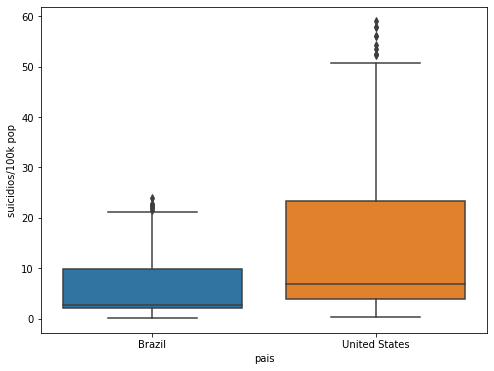

In [ ]:
pais_vs_pais('United States','Brazil')

Tamanho das amostras do país Albania: 22
Tamanho das amostras do país Brazil: 31
Teste usado: T-student
--------RESULTADO--------
a média do país Albania é menor que a média do país Brazil


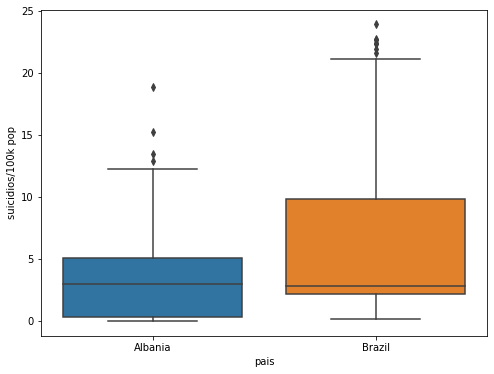

In [ ]:
pais_vs_pais('Albania','Brazil')

Tamanho das amostras do país Guatemala: 30
Tamanho das amostras do país Brazil: 31
Teste usado: Z-Test
--------RESULTADO--------
a média do país Guatemala é menor que a média do país Brazil


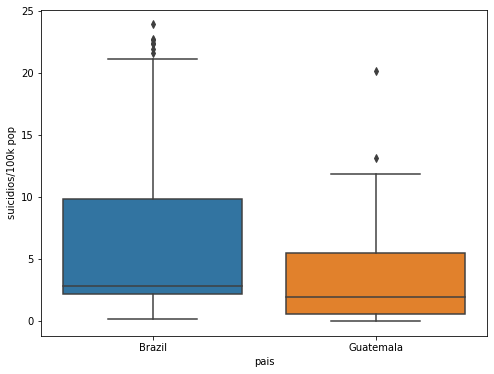

In [ ]:
pais_vs_pais('Guatemala','Brazil')

Tamanho das amostras do país Aruba: 14
Tamanho das amostras do país Brazil: 31
Teste usado: T-student
--------RESULTADO--------
a média do país Aruba é maior que a média do país Brazil


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


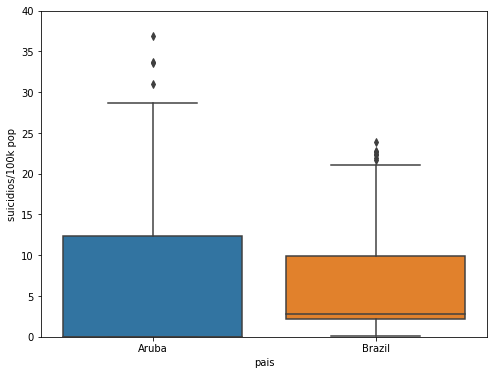

In [ ]:
pais_vs_pais('Aruba','Brazil', limite = 40)

Tamanho das amostras do país Portugal: 27
Tamanho das amostras do país Brazil: 31
Teste usado: T-student
--------RESULTADO--------
a média do país Portugal é maior que a média do país Brazil


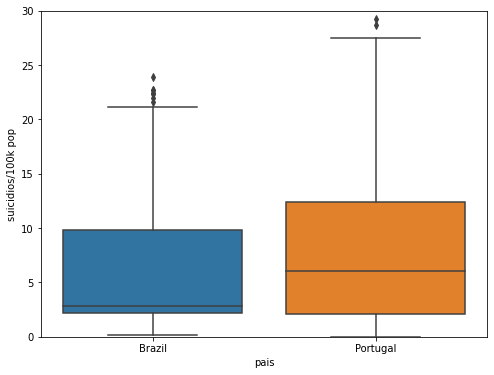

In [ ]:
pais_vs_pais('Portugal','Brazil', limite = 30)

Tamanho das amostras do país Antigua and Barbuda: 27
Tamanho das amostras do país Brazil: 31
Teste usado: Mannwhitneyu
--------RESULTADO--------
O pais Antigua and Barbuda teve medidas menores que o pais Brazil


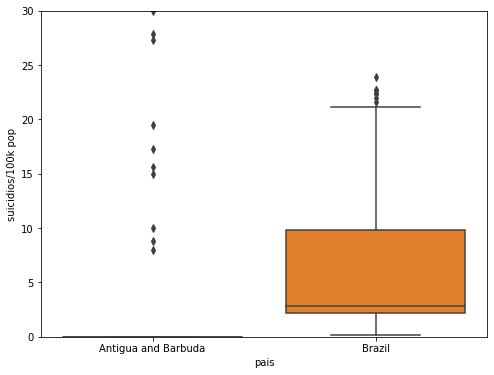

In [ ]:
pais_vs_pais('Antigua and Barbuda','Brazil', limite = 30)

Tamanho das amostras do país Austria: 32
Tamanho das amostras do país Brazil: 31
Teste usado: Z-Test
--------RESULTADO--------
a média do país Austria é maior que a média do país Brazil


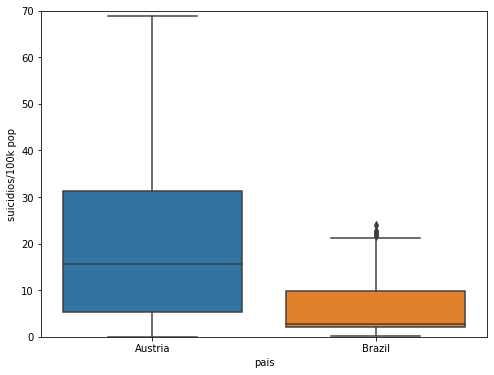

In [ ]:
pais_vs_pais('Austria','Brazil', limite = 70)

Tamanho das amostras do país Chile: 31
Tamanho das amostras do país Italy: 31
Teste usado: Mannwhitneyu
--------RESULTADO--------
As amostras possuem medidas iguais


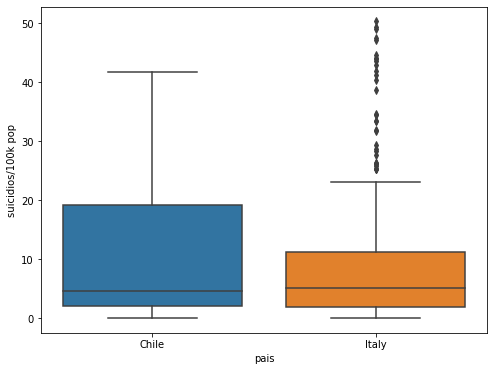

In [ ]:
pais_vs_pais('Chile','Italy')

Tamanho das amostras do país Chile: 31
Tamanho das amostras do país Brazil: 31
Teste usado: Mannwhitneyu
--------RESULTADO--------
O pais Brazil teve medidas menores que o pais Chile


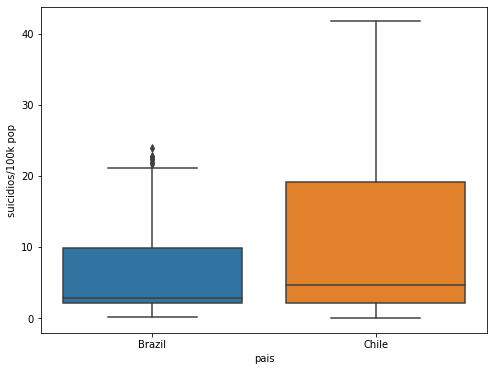

In [ ]:
pais_vs_pais('Chile','Brazil')

Tamanho das amostras do país Chile: 31
Tamanho das amostras do país Colombia: 31
Teste usado: Mannwhitneyu
--------RESULTADO--------
O pais Colombia teve medidas menores que o pais Chile


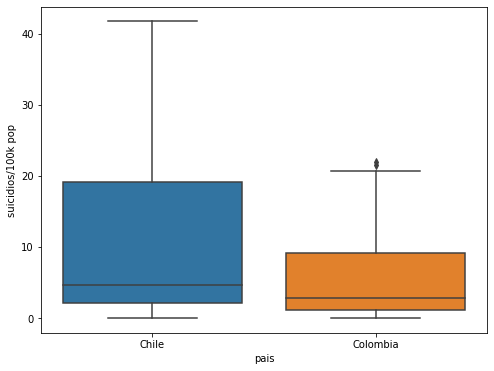

In [ ]:
pais_vs_pais('Chile','Colombia')

Tamanho das amostras do país Chile: 31
Tamanho das amostras do país Brazil: 31
Teste usado: Mannwhitneyu
--------RESULTADO--------
O pais Brazil teve medidas menores que o pais Chile


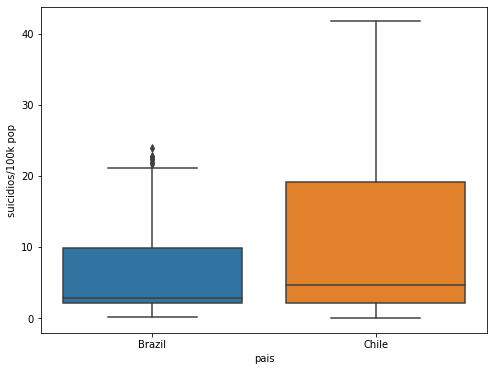

In [ ]:
pais_vs_pais('Chile','Brazil')

Tamanho das amostras do país Cuba: 24
Tamanho das amostras do país Brazil: 31
Teste usado: T-student
--------RESULTADO--------
a média do país Cuba é maior que a média do país Brazil


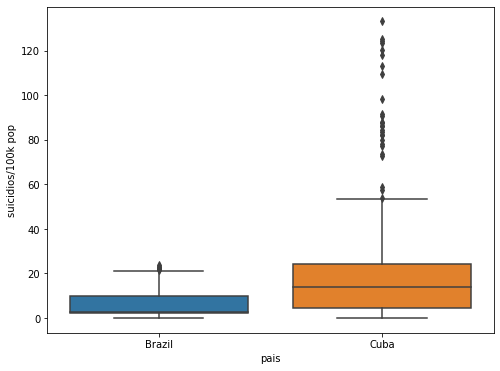

In [ ]:
pais_vs_pais('Cuba','Brazil')

Tamanho das amostras do país Japan: 31
Tamanho das amostras do país United States: 31
Teste usado: Mannwhitneyu
--------RESULTADO--------
O pais United States teve medidas menores que o pais Japan


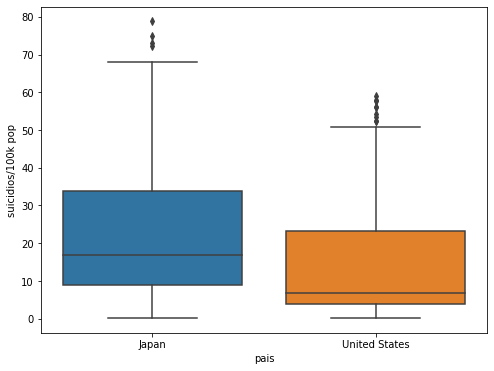

In [ ]:
pais_vs_pais('Japan','United States')

### Quarta Análise
> Países Pobres X Países Ricos - Análise estátistica

#### PIB per capita

In [ ]:
# Concertando PIB
PIB_corrigido = list()

for linha in range(len(df)):
  amostra = df.iloc[linha]
  PIB = amostra['PIB_por_ano']
  PIB_corrigido.append(int(PIB.replace(',','')))

df['PIB_por_ano'] = PIB_corrigido
df.head()

,pais,ano,sexo,idade_do_grupo,num_suicidios,populacao,suicidios/100k pop,pais_ano,IDH_por_ano,PIB_por_ano,PIB_per_capita,geracao
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers


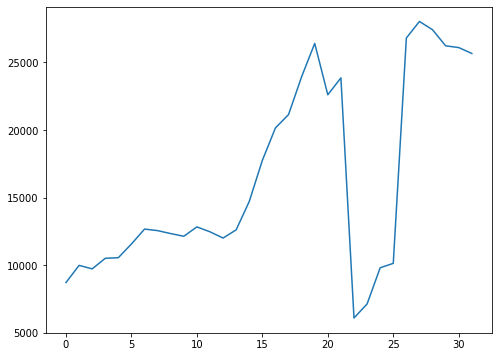

In [ ]:
t = list()
for ano in df.ano.unique():
  a = df.query(f'ano == {ano}').PIB_per_capita
  t.append(a.mean())

plt.figure(figsize = (8,6))
plt.plot(t)

**O PIB PER CAPITA É DIRETAMENTE PROPORCIONAL AO ANO,LOGO, UM PAIS POBRE EM 2019 PODE SER CONSIDERADO RICO EM 2000, AS CÉLULAS ABAIXO ARRUMAM ISSO**

In [ ]:
index = {'paises_pobres':[],'paises_medios':[],'paises_ricos':[]}

for ano in df.ano.unique():
  a = df.query(f'ano == {ano}')
  q1,q2 = a.PIB_per_capita.quantile([0.25, 0.75])

  index['paises_pobres'].extend(a[a['PIB_per_capita'] <= q1].index.tolist())
  index['paises_medios'].extend(a[(a['PIB_per_capita'] > q1) & (a['PIB_per_capita'] < q2)].index.tolist())
  index['paises_ricos'].extend(a[a['PIB_per_capita'] >= q2].index.tolist())

_ = len(index['paises_pobres'])
print('Numero de paises pobres: %i' % (_))

_ = len(index['paises_medios'])
print('Numero de paises medios: %i' % (_))

_ = len(index['paises_ricos'])
print('Numero de paises ricos: %i' % (_))

#7108 + 13616 + 7096 == len(df)

Numero de paises pobres: 7108
Numero de paises medios: 13616
Numero de paises ricos: 7096


In [ ]:
paises_pobres = df.iloc[index['paises_pobres']]
paises_medios = df.iloc[index['paises_medios']]
paises_ricos = df.iloc[index['paises_ricos']]

##### Gráficos

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0.0, 50.0)

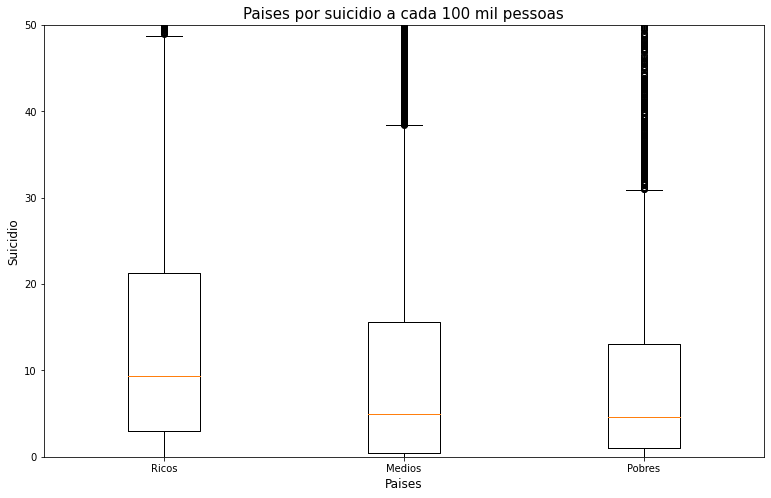

In [ ]:
figure = plt.figure(figsize = (10,6))
ax = figure.add_axes([0,0,1,1])

ax.boxplot([paises_ricos['suicidios/100k pop'],paises_medios['suicidios/100k pop'],paises_pobres['suicidios/100k pop']], labels = ['Ricos','Medios','Pobres'])
ax.set_title('Paises por suicidio a cada 100 mil pessoas', fontsize = 15)
ax.set_xlabel('Paises', fontsize = 12)
ax.set_ylabel('Suicidio', fontsize = 12)

ax.set_ylim(0,50)

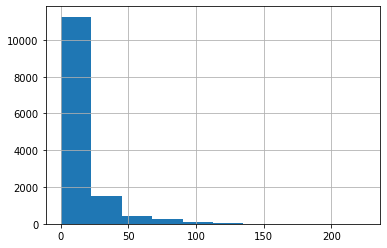

In [ ]:
paises_medios['suicidios/100k pop'].hist()

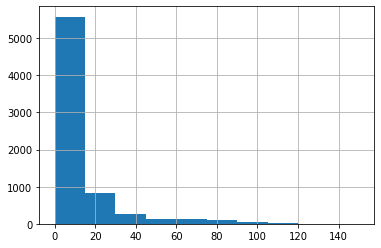

In [ ]:
paises_pobres['suicidios/100k pop'].hist()

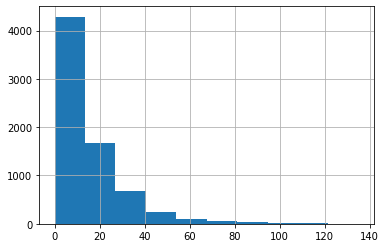

In [ ]:
paises_ricos['suicidios/100k pop'].hist()

##### Testes não-paramétricos

In [ ]:
_, p1 = normaltest(paises_pobres['suicidios/100k pop'])
_, p2 = normaltest(paises_medios['suicidios/100k pop'])
_, p3 = normaltest(paises_ricos['suicidios/100k pop'])

if verificar_teste(p1) == verificar_teste(p2) == verificar_teste(p3) == True:
  print('H0')
elif verificar_teste(p1) == verificar_teste(p2) == verificar_teste(p3) == False:
  print('H1')


print(p1,p2,p3)
# TESTES NÃO PARAMÉTRICOS

H1
0.0 0.0 0.0


In [ ]:
print(paises_pobres['suicidios/100k pop'].isna().sum())
print(paises_medios['suicidios/100k pop'].isna().sum())
print(paises_ricos['suicidios/100k pop'].isna().sum())

print('--------')

print(len(paises_pobres))
print(len(paises_medios))
print(len(paises_ricos))
# Sem valores nan's

0
0
0
--------
7108
13616
7096


In [ ]:
def comparar_pib(classe_1_str,classe_2_str):
  paises = {'pobres':paises_pobres['suicidios/100k pop'],'medios':paises_medios['suicidios/100k pop'],'ricos':paises_ricos['suicidios/100k pop']}
  s1 = paises[classe_1_str.lower()]
  s2 = paises[classe_2_str.lower()]

  if len(s1) > len(s2):
    classe_1 = s2
    classe_2 = s1

    nome_1 = classe_2_str
    nome_2 = classe_1_str
  else:
    classe_1 = s1
    classe_2 = s2

    nome_1 = classe_1_str
    nome_2 = classe_2_str
    

  _,p_valor = mannwhitneyu(classe_1,classe_2,alternative = 'two-sided')
    
  if verificar_teste(p_valor):
    print('As classes possuem medidas iguais')
  else:
    _,p_valor = mannwhitneyu(classe_1,classe_2,alternative = 'greater')

    if verificar_teste(p_valor):
      print(f'Os paises {nome_1} tem medidas menores que os paises {nome_2}')
    else:
      print(f'Os paises {nome_1} tem medidas maiores que os paises {nome_2}')

In [ ]:
# Pobre X Médios
comparar_pib('Pobres','Medios')

As classes possuem medidas iguais


In [ ]:
#Pobres X Ricos
comparar_pib('Ricos','Pobres')

Os paises Ricos tem medidas maiores que os paises Pobres


In [ ]:
#Ricos X Médios
comparar_pib('Ricos','Medios')

Os paises Ricos tem medidas maiores que os paises Medios


**Conclusão**: Nos paises ricos, a taxa de suícidio é maior que a dos paises médios e pobres. 

Nos paises pobres e médios a taxa de suícidio tem medidas iguais.

#### IDH

#####Repondo informações

In [ ]:
df[df.IDH_por_ano.isna()].ano.unique()
# Anos com valores nan's

array([1987, 1988, 1989, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2001,
       2002, 2003, 2004, 2006, 2007, 2008, 2009, 1985, 1986, 1990, 1991,
       1995, 2000, 2005, 2015, 2016, 2010, 2011, 2012, 2013, 2014])

In [ ]:
df.head()

,pais,ano,sexo,idade_do_grupo,num_suicidios,populacao,suicidios/100k pop,pais_ano,IDH_por_ano,PIB_por_ano,PIB_per_capita,geracao
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers


In [ ]:
idh.head()

,HDI Rank,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,169,Afghanistan,0.302,0.307,0.316,0.312,0.307,0.331,0.335,0.339,0.344,0.348,0.350,0.353,0.384,0.393,0.409,0.418,0.429,0.447,0.447,0.460,0.472,0.477,0.489,0.496,0.500,0.500,0.502,0.506,0.509,0.511
1,69,Albania,0.650,0.631,0.615,0.618,0.624,0.637,0.646,0.645,0.655,0.665,0.671,0.678,0.684,0.691,0.696,0.706,0.713,0.722,0.728,0.733,0.745,0.764,0.775,0.782,0.787,0.788,0.788,0.790,0.792,0.795
2,91,Algeria,0.572,0.576,0.582,0.586,0.590,0.595,0.602,0.611,0.621,0.629,0.637,0.647,0.657,0.667,0.677,0.685,0.690,0.700,0.702,0.711,0.721,0.728,0.728,0.729,0.736,0.740,0.743,0.745,0.746,0.748
3,36,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813,0.815,0.820,0.827,0.833,0.827,0.837,0.837,0.840,0.839,0.837,0.836,0.858,0.856,0.863,0.862,0.866,0.863,0.867,0.868
4,148,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.391,0.400,0.410,0.426,0.435,0.446,0.460,0.473,0.489,0.501,0.515,0.517,0.533,0.544,0.555,0.565,0.572,0.578,0.582,0.582,0.581


In [ ]:
amostras_nan = df[df.IDH_por_ano.isna()].copy()
paises_com_idh = idh.Country.unique()
anos_com_idh = idh.columns[2:]

idhs = list()
for i in range(len(amostras_nan)):
  amostra = amostras_nan.iloc[i]
  amostra_pais = amostra.pais
  amostra_ano = str(amostra.ano)

  if (amostra_pais in paises_com_idh) and (amostra_ano in anos_com_idh):
    idh_pais = float(idh.query(f'Country == "{amostra_pais}"')[amostra_ano].values[0])
    idhs.append(idh_pais)
  else:
    idhs.append(np.nan)

amostras_nan['IDH_por_ano'] = idhs
df[df.IDH_por_ano.isna()] = amostras_nan

In [ ]:
df.isna().sum() 

pais                     0
ano                      0
sexo                     0
idade_do_grupo           0
num_suicidios            0
populacao                0
suicidios/100k pop       0
pais_ano                 0
IDH_por_ano           5218
PIB_por_ano              0
PIB_per_capita           0
geracao                  0
dtype: int64

In [ ]:
(df.isna().sum() / len(df))*100

#de 70% dos dados nan virou 18%

pais                   0.00000
ano                    0.00000
sexo                   0.00000
idade_do_grupo         0.00000
num_suicidios          0.00000
populacao              0.00000
suicidios/100k pop     0.00000
pais_ano               0.00000
IDH_por_ano           18.75629
PIB_por_ano            0.00000
PIB_per_capita         0.00000
geracao                0.00000
dtype: float64

In [ ]:
# Droparemos os 18 %
df4 = df.dropna().copy()
len(df4)

22602

In [ ]:
df4.head()

,pais,ano,sexo,idade_do_grupo,num_suicidios,populacao,suicidios/100k pop,pais_ano,IDH_por_ano,PIB_por_ano,PIB_per_capita,geracao
36,Albania,1992,male,35-54 years,12,343800,3.49,Albania1992,0.615,709452584,251,Boomers
37,Albania,1992,male,15-24 years,9,263700,3.41,Albania1992,0.615,709452584,251,Generation X
38,Albania,1992,male,55-74 years,5,159500,3.13,Albania1992,0.615,709452584,251,Silent
39,Albania,1992,male,25-34 years,7,245500,2.85,Albania1992,0.615,709452584,251,Boomers
40,Albania,1992,female,15-24 years,7,292400,2.39,Albania1992,0.615,709452584,251,Generation X


##### Criando Grupos

In [ ]:
niveis = idh.query("Country in ['Very high human development', 'High human development','Medium human development', 'Low human development']").copy()

niveis.rename(mapper = {'Country':'Nivel'}, axis = 1, inplace = True)
niveis.reset_index(inplace=True)
niveis.drop(columns = ['HDI Rank','index'],inplace = True)
niveis.Nivel = ['Muito Alto','Alto','Medio','Baixo']
niveis

,Nivel,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Muito Alto,0.779,0.782,0.780,0.790,0.795,0.799,0.804,0.804,0.813,0.818,0.823,0.827,0.832,0.837,0.841,0.846,0.851,0.855,0.860,0.861,0.866,0.871,0.874,0.878,0.882,0.886,0.888,0.890,0.892,0.898
1,Alto,0.568,0.573,0.578,0.584,0.588,0.596,0.604,0.610,0.616,0.622,0.630,0.636,0.643,0.650,0.657,0.665,0.675,0.684,0.692,0.698,0.706,0.713,0.720,0.727,0.733,0.738,0.743,0.746,0.750,0.753
2,Medio,0.437,0.439,0.445,0.451,0.457,0.464,0.471,0.476,0.484,0.491,0.497,0.502,0.508,0.518,0.527,0.536,0.544,0.553,0.560,0.567,0.575,0.584,0.593,0.599,0.608,0.616,0.625,0.630,0.634,0.631
3,Baixo,0.352,0.353,0.355,0.356,0.356,0.361,0.368,0.373,0.379,0.384,0.386,0.393,0.402,0.417,0.426,0.435,0.444,0.452,0.461,0.469,0.473,0.479,0.484,0.490,0.496,0.499,0.501,0.505,0.507,0.513


In [ ]:
df4.drop(columns = ['sexo','idade_do_grupo','PIB_por_ano','PIB_per_capita','geracao'],inplace = True)
df4.head()

,pais,ano,num_suicidios,populacao,suicidios/100k pop,pais_ano,IDH_por_ano
36,Albania,1992,12,343800,3.49,Albania1992,0.615
37,Albania,1992,9,263700,3.41,Albania1992,0.615
38,Albania,1992,5,159500,3.13,Albania1992,0.615
39,Albania,1992,7,245500,2.85,Albania1992,0.615
40,Albania,1992,7,292400,2.39,Albania1992,0.615


In [ ]:
# Criando classes
classe = {0:'Muito Baixo', 1:'Baixo', 2:'Médio', 3:'Alto', 4:'Muito Alto'}
lista = list()

for i in range(len(df4)):
  amostra = df4.iloc[i]
  ano = str(amostra.ano)
  idh = amostra.IDH_por_ano

  if ano != '1985': # Existe amostras que tem ano de 1985, nessas amostras os dados do idh não possuem a coluna necessária
    v1,v2,v3,v4 = niveis[ano].astype(np.float32).values
  else:
    v1,v2,v3,v4 = df4.query('ano == %i' % (int(ano))).IDH_por_ano.quantile([0.2, 0.4, 0.6, 0.8])

  # Adicionando a lista
  if (idh < v1):
    lista.append(0)
    
  elif (idh >= v1) and (idh < v2):
    lista.append(1)
    
  elif (idh >= v2) and (idh < v3):
    lista.append(2)

  elif (idh >= v3) and (idh < v4):
    lista.append(3)

  else:
    lista.append(4)
  
df4['IDH_grupo'] = lista
df4['IDH_grupo'].replace(classe, inplace=True)

##### Gráficos

In [ ]:
f = df4['IDH_grupo'].value_counts()
p = df4['IDH_grupo'].value_counts(normalize = True) * 100

_ = pd.DataFrame([f,p])[['Muito Alto','Alto','Médio','Baixo','Muito Baixo']].T
_.columns = ['Frequencia','Porcentagem (%)']
_['Frequencia'] = _['Frequencia'].astype(np.int32)
_

,Frequencia,Porcentagem (%)
Muito Alto,7000,30.970711
Alto,84,0.371649
Médio,96,0.424741
Baixo,84,0.371649
Muito Baixo,15338,67.861251


(0.0, 60.0)

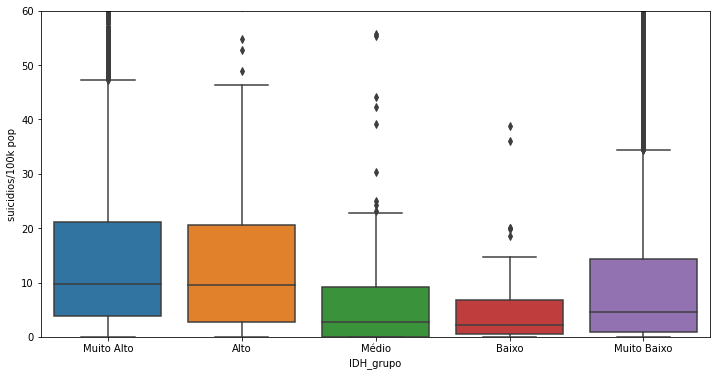

In [ ]:
ax = sns.boxplot(x = 'IDH_grupo', y = 'suicidios/100k pop', data = df4,order = ['Muito Alto','Alto','Médio','Baixo','Muito Baixo'])
ax.figure.set_size_inches(12,6)
ax.set_ylim(0,60)

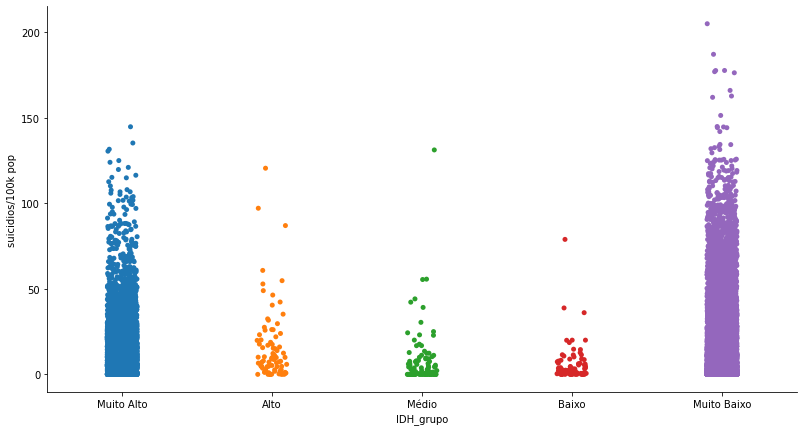

In [ ]:
ax = sns.catplot(x = 'IDH_grupo', y = 'suicidios/100k pop', data = df4, order = ['Muito Alto','Alto','Médio','Baixo','Muito Baixo'])
ax.fig.set_size_inches(12,6)

--------------
Muito Baixo
H1


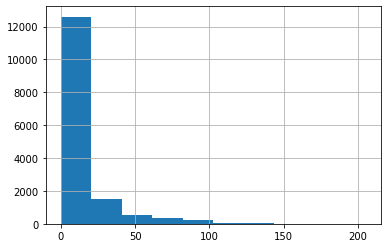

--------------
Médio
H1


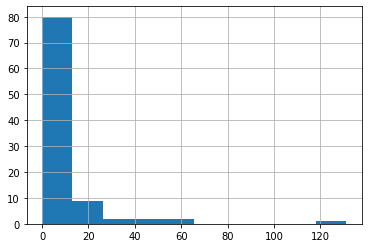

--------------
Muito Alto
H1


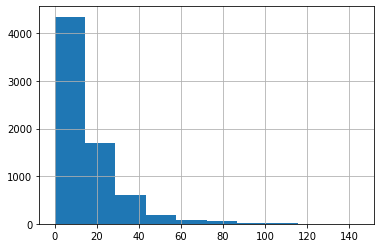

--------------
Alto
H1


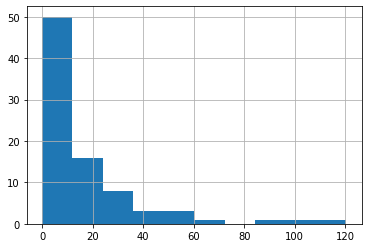

--------------
Baixo
H1


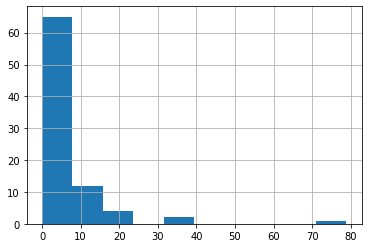

In [ ]:
for i in df4.IDH_grupo.unique():
  a = df4[df4.IDH_grupo == i]['suicidios/100k pop']
  print('--------------')
  print(i)

  stat,p_valor = normaltest(a)
  r = verificar_teste(p_valor)
  if r:
    print('H0')
  else:
    print('H1')

  a.hist()
  plt.show()

##### Testes Não-Paramétricos

In [ ]:
_ = pd.DataFrame([f,p])[['Muito Alto','Alto','Médio','Baixo','Muito Baixo']].T
_.columns = ['Frequencia','Porcentagem (%)']
_['Frequencia'] = _['Frequencia'].astype(np.int32)
_
# Relembrando a frequencia

,Frequencia,Porcentagem (%)
Muito Alto,7000,30.970711
Alto,84,0.371649
Médio,96,0.424741
Baixo,84,0.371649
Muito Baixo,15338,67.861251


In [ ]:
df4.head()

,pais,ano,num_suicidios,populacao,suicidios/100k pop,pais_ano,IDH_por_ano,IDH_grupo
36,Albania,1992,12,343800,3.49,Albania1992,0.615,Muito Baixo
37,Albania,1992,9,263700,3.41,Albania1992,0.615,Muito Baixo
38,Albania,1992,5,159500,3.13,Albania1992,0.615,Muito Baixo
39,Albania,1992,7,245500,2.85,Albania1992,0.615,Muito Baixo
40,Albania,1992,7,292400,2.39,Albania1992,0.615,Muito Baixo


In [ ]:
lista_de_classes = [i for i in combinations(df4.IDH_grupo.unique(), 2)]

for i in lista_de_classes:
  print('-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==')
  classe_1 = df4[df4.IDH_grupo == i[0]]['suicidios/100k pop']
  classe_2 = df4[df4.IDH_grupo == i[1]]['suicidios/100k pop']

  if len(classe_1) <= len(classe_2):
    x = classe_1
    y = classe_2

    x_nome = i[0]
    y_nome = i[1]

  else:
    x = classe_2
    y = classe_1

    x_nome = i[1]
    y_nome = i[0]

  u, p_valor = mannwhitneyu(x,y, alternative = 'two-sided')
  if verificar_teste(p_valor): # Funcao retorna True se for H0
    print(f'As amostras {x_nome} e {y_nome} possuem medidas iguais')# H0

  else:#H1
    u, p_valor = mannwhitneyu(x,y, alternative = 'greater')

    if verificar_teste(p_valor):# H0
      print(f'As medidas do grupo {y_nome} são maiores que as medidas do grupo {x_nome}')
    
    else:#H1
      print(f'As medidas do grupo {x_nome} são maiores que as medidas do grupo {y_nome}')

-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Muito Baixo são maiores que as medidas do grupo Médio
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Muito Alto são maiores que as medidas do grupo Muito Baixo
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Alto são maiores que as medidas do grupo Muito Baixo
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Muito Baixo são maiores que as medidas do grupo Baixo
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Muito Alto são maiores que as medidas do grupo Médio
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Alto são maiores que as medidas do grupo Médio
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As amostras Baixo e Médio possuem medidas iguais
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As amostras Alto e Muito Alto possuem medidas iguais
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Muito Alto são maiores que as medidas do grupo Baixo
-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==
As medidas do grupo Alto são maiores que as medidas do 

(0.0, 60.0)

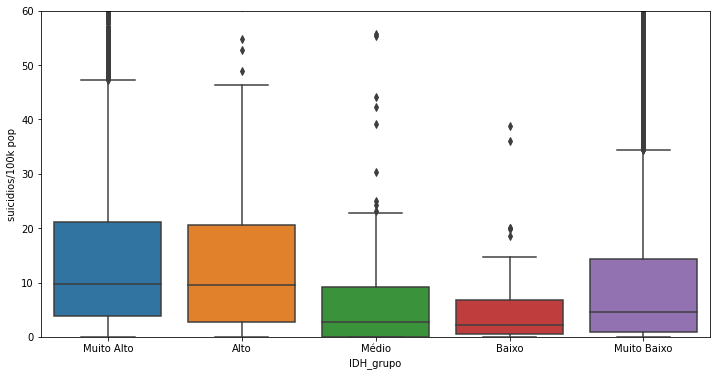

In [ ]:
ax = sns.boxplot(x = 'IDH_grupo', y = 'suicidios/100k pop', data = df4,order = ['Muito Alto','Alto','Médio','Baixo','Muito Baixo'])
ax.figure.set_size_inches(12,6)
ax.set_ylim(0,60)

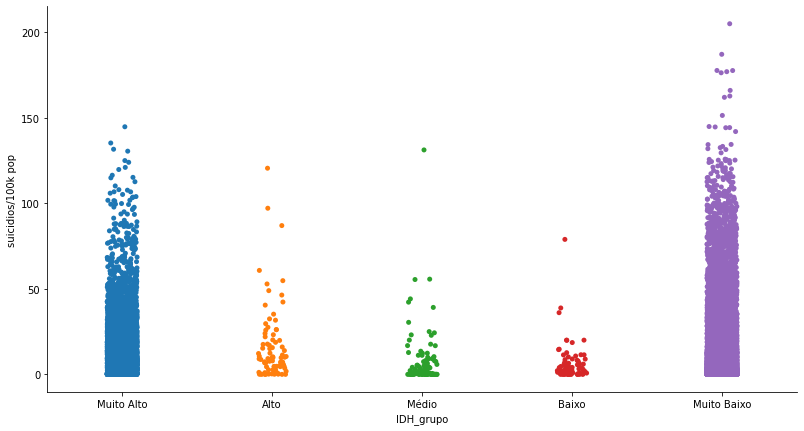

In [ ]:
ax = sns.catplot(x = 'IDH_grupo', y = 'suicidios/100k pop', data = df4, order = ['Muito Alto','Alto','Médio','Baixo','Muito Baixo'])
ax.fig.set_size_inches(12,6)

**Conclusão: Grupos com IDH alto e muito alto lideram o numero de suicidios; O grupo muito baixo vem em segundo lugar; E os grupos com menos números de suícidios são os grupos Médios e Baixos**


OBS:. Parece até uma curva onde o vértice da curva se encontra no grupo médio/baixo

### Quinta Análise
> Pais X Mundo - Análise estátistica

In [ ]:
def plot_pais_vs_mundo(pais,y_lim = 45):
  # Pegando dados
  s_pais = df.query(f'pais == "{pais}"')['suicidios/100k pop']
  s_mundo = df.query(f'pais != "{pais}"')['suicidios/100k pop']

  # Plot
  fig = plt.figure(figsize = (6,5))
  ax = fig.add_axes([0,0,1,1])

  ax.boxplot([s_mundo,s_pais], labels =['Mundo',pais])
  ax.grid(True, lw = 0.6, linestyle = ':')

  ax.set_ylabel('Suicidios a cada 100k de pop', fontsize = 10)
  ax.set_ylim((0,y_lim))

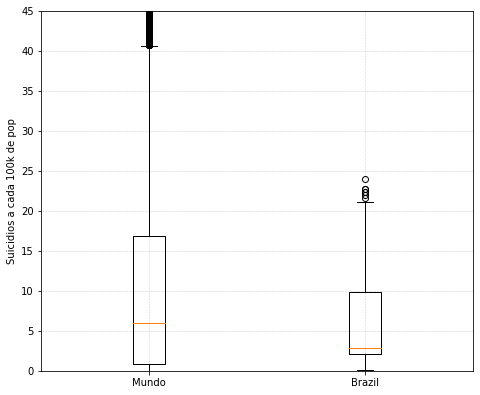

In [ ]:
plot_pais_vs_mundo('Brazil')

In [ ]:
# NENHUM PAIS POSSUI DISTRIBUIÇÃO NORMAL
def pais_vs_mundo(pais):
  s_pais = df.query(f'pais == "{pais}"')['suicidios/100k pop']
  s_mundo = df.query(f'pais != "{pais}"')['suicidios/100k pop']


  plot_pais_vs_mundo(pais = pais) # Plot

  if len(s_pais) < len(s_mundo):
    x = s_pais
    y = s_mundo

    x_nome = pais
    y_nome = 'Mundo'
  else:
    x = s_mundo
    y = s_pais

    x_nome = 'Mundo'
    y_nome = pais


  t,p_valor = mannwhitneyu(x,y, alternative = 'two-sided')
  teste = verificar_teste(p_valor)

  if teste:
    print(f'O pais {pais} tem medidas iguais ao mundo')

  else:
    t,p_valor = mannwhitneyu(x,y, alternative = 'less')
    teste = verificar_teste(p_valor)

    if teste:
      print(f'{x_nome} tem medidas maiores que {y_nome}')
    
    else:
      print(f'{x_nome} tem medidas menores que {y_nome}')

Brazil tem medidas menores que Mundo


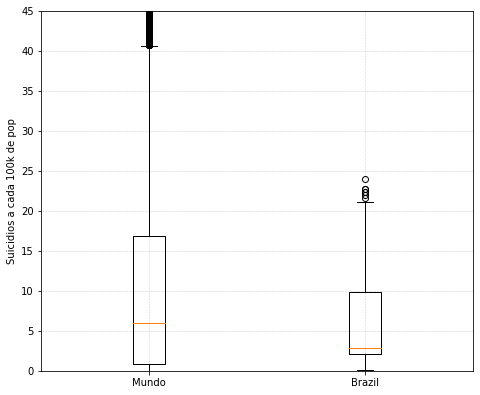

In [ ]:
pais_vs_mundo('Brazil')

United States tem medidas maiores que Mundo


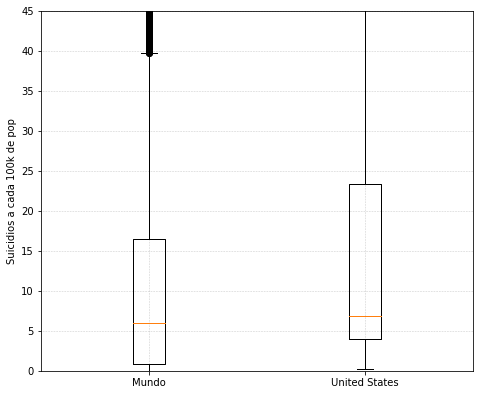

In [ ]:
pais_vs_mundo('United States')

Germany tem medidas maiores que Mundo


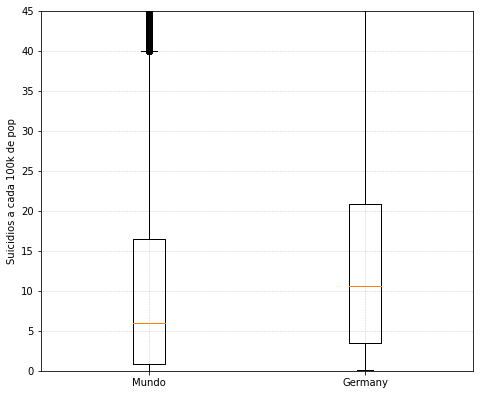

In [ ]:
pais_vs_mundo('Germany')

Colombia tem medidas menores que Mundo


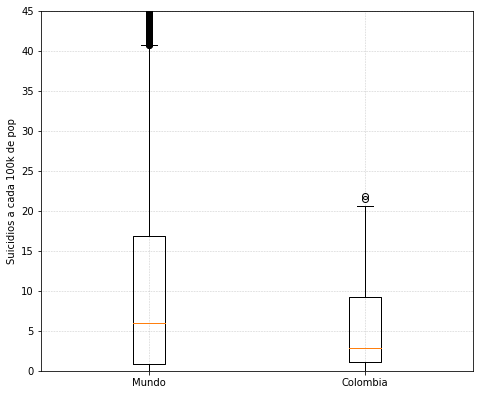

In [ ]:
pais_vs_mundo('Colombia')

Argentina tem medidas maiores que Mundo


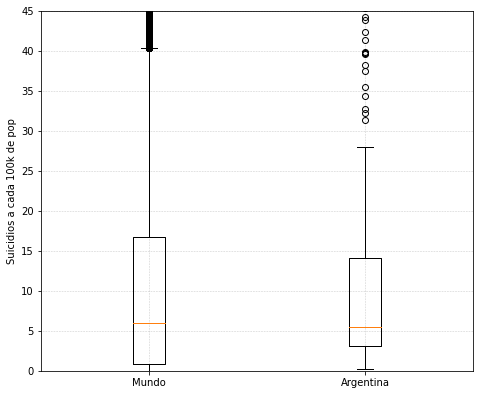

In [ ]:
pais_vs_mundo('Argentina')

O pais United Kingdom tem medidas iguais ao mundo


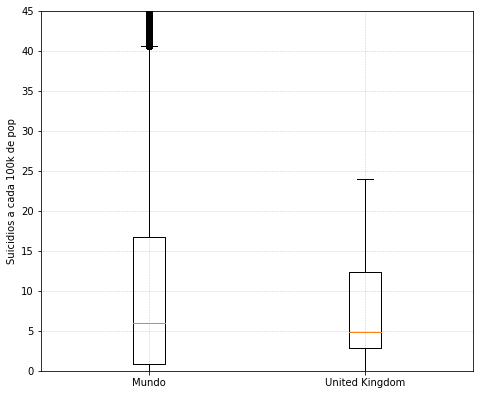

In [ ]:
pais_vs_mundo('United Kingdom')

O pais Israel tem medidas iguais ao mundo


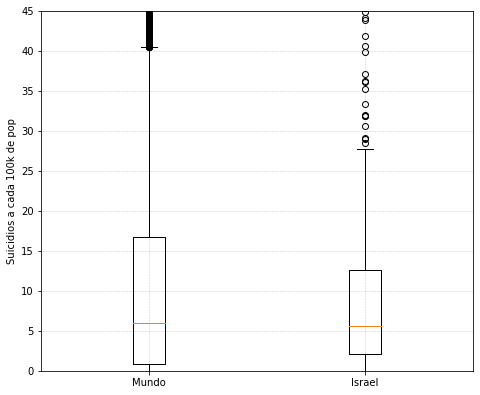

In [ ]:
pais_vs_mundo('Israel')

Cuba tem medidas maiores que Mundo


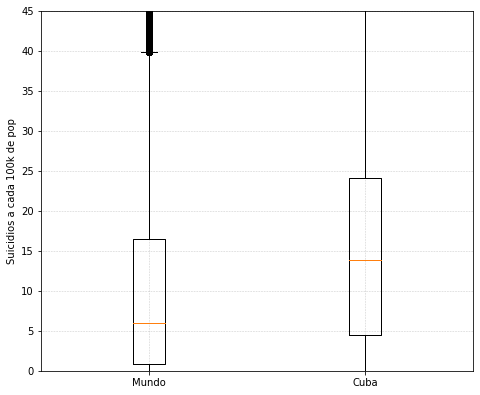

In [ ]:
pais_vs_mundo('Cuba')

Uruguay tem medidas maiores que Mundo


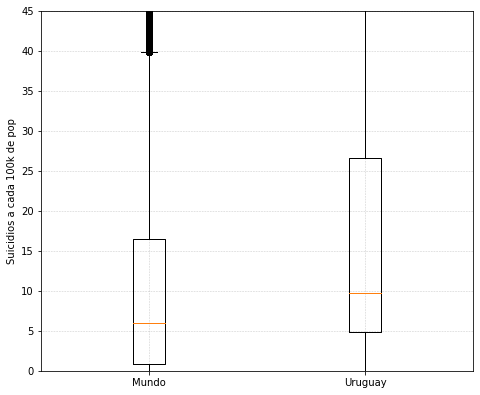

In [ ]:
pais_vs_mundo('Uruguay')

Japan tem medidas maiores que Mundo


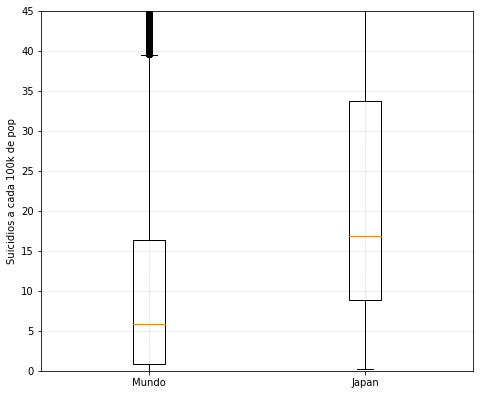

In [ ]:
pais_vs_mundo('Japan')

### Sexta Análise
> Idades X Idades - Análise estátistica

In [ ]:
for i in df.idade_do_grupo.unique():
  a = df.query(f'idade_do_grupo == "{i}"')['suicidios/100k pop']
  _,p_valor = normaltest(a)

  teste = verificar_teste(p_valor)

  if teste:
    print(f'{i} // H0')
  else:
    print(f'{i} // H1')

15-24 years // H1
35-54 years // H1
75+ years // H1
25-34 years // H1
55-74 years // H1
5-14 years // H1


In [ ]:
df.idade_do_grupo.unique()

array(['15-24 years', '35-54 years', '75+ years', '25-34 years',
       '55-74 years', '5-14 years'], dtype=object)

(0.0, 100.0)

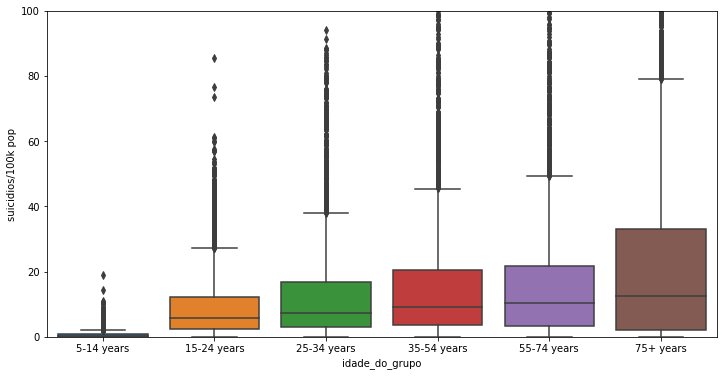

In [ ]:
ax = sns.boxplot(x = 'idade_do_grupo', y = 'suicidios/100k pop', data = df, order = ['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years'])
ax.figure.set_size_inches(12,6)
ax.set_ylim(0,100)

In [ ]:
lista_de_classes = [i for i in combinations(df.idade_do_grupo.unique(), 2)]

for a1,a2 in lista_de_classes:
  print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
  s1 = df.query(f'idade_do_grupo == "{a1}"')['suicidios/100k pop']
  s2 = df.query(f'idade_do_grupo == "{a2}"')['suicidios/100k pop']

  if len(s1) < len(s2):
    x = s1
    y = s2

    x_nome = a1
    y_nome = a2
  else:
    x = s2
    y = s1

    x_nome = a2
    y_nome = a1


  t,p_valor = mannwhitneyu(x,y, alternative = 'two-sided')
  teste = verificar_teste(p_valor)

  if teste:
    print(f'O grupo {x_nome} tem medidas iguais ao grupo {y_nome}')

  else:
    t,p_valor = mannwhitneyu(x,y, alternative = 'less')
    teste = verificar_teste(p_valor)

    if teste:
      print(f'O grupo {x_nome} tem medidas maiores que o grupo {y_nome}')
    
    else:
      print(f'O grupo {x_nome} tem medidas menores que o grupo {y_nome}')

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 35-54 years tem medidas maiores que o grupo 15-24 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 75+ years tem medidas maiores que o grupo 15-24 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 25-34 years tem medidas maiores que o grupo 15-24 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 55-74 years tem medidas maiores que o grupo 15-24 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 5-14 years tem medidas menores que o grupo 15-24 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 75+ years tem medidas maiores que o grupo 35-54 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 25-34 years tem medidas menores que o grupo 35-54 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 55-74 years tem medidas maiores que o grupo 35-54 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 5-14 years tem medidas menores que o grupo 35-54 years
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
O grupo 25-34 years 

***Conclusão: Podemos ver que quanto mais velho o grupo fica, mais casos de suicídio possui***

### Sétima Análise
> Geração X Geração - Análise estátistica

In [ ]:
for i in df.geracao.unique():
  a = df.query(f'geracao == "{i}"')['suicidios/100k pop']
  _,p_valor = normaltest(a)

  teste = verificar_teste(p_valor)

  if teste:
    print(f'{i} // H0')
  else:
    print(f'{i} // H1')

Generation X // H1
Silent // H1
G.I. Generation // H1
Boomers // H1
Millenials // H1
Generation Z // H1


In [ ]:
_ = df.geracao.unique()

cronologia = [_[2], _[1], _[-3], _[0], _[-2], _[-1]]
cronologia

['G.I. Generation',
 'Silent',
 'Boomers',
 'Generation X',
 'Millenials',
 'Generation Z']

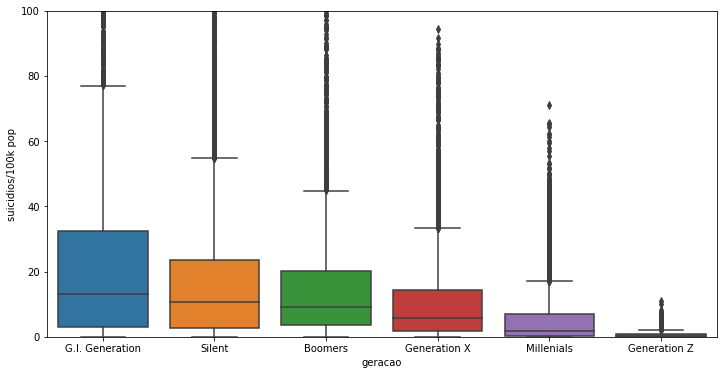

In [ ]:
ax = sns.boxplot(x = 'geracao', y = 'suicidios/100k pop', data = df, order = cronologia)
ax.figure.set_size_inches(12,6)
ax.set_ylim(0,100)

In [ ]:
lista_de_classes = [i for i in combinations(cronologia, 2)]

for a1,a2 in lista_de_classes:
  print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
  s1 = df.query(f'geracao == "{a1}"')['suicidios/100k pop']
  s2 = df.query(f'geracao == "{a2}"')['suicidios/100k pop']

  if len(s1) < len(s2):
    x = s1
    y = s2

    x_nome = a1
    y_nome = a2
  else:
    x = s2
    y = s1

    x_nome = a2
    y_nome = a1


  t,p_valor = mannwhitneyu(x,y, alternative = 'two-sided')
  teste = verificar_teste(p_valor)

  if teste:
    print(f'A geração {x_nome} tem medidas iguais a geração {y_nome}')

  else:
    t,p_valor = mannwhitneyu(x,y, alternative = 'less')
    teste = verificar_teste(p_valor)

    if teste:
      print(f'A geração {x_nome} tem medidas maiores que a geração {y_nome}')
    
    else:
      print(f'A geração {x_nome} tem medidas menores que a geração {y_nome}')

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração G.I. Generation tem medidas maiores que a geração Silent
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração G.I. Generation tem medidas maiores que a geração Boomers
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração G.I. Generation tem medidas maiores que a geração Generation X
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração G.I. Generation tem medidas maiores que a geração Millenials
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração Generation Z tem medidas menores que a geração G.I. Generation
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração Boomers tem medidas menores que a geração Silent
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração Silent tem medidas maiores que a geração Generation X
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração Millenials tem medidas menores que a geração Silent
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
A geração Generation Z tem medidas menores que a geração Silent
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

***Conclusão: Conforme a geração passa, menos suicídios acontece***

### Oitava Análise
> Sexo X Sexo - Análise estátistica

In [ ]:
df.sexo = df.sexo.map({'male':'Homem','female':'Mulher'})

Text(0.5, 1.0, 'Suicidios por genero')

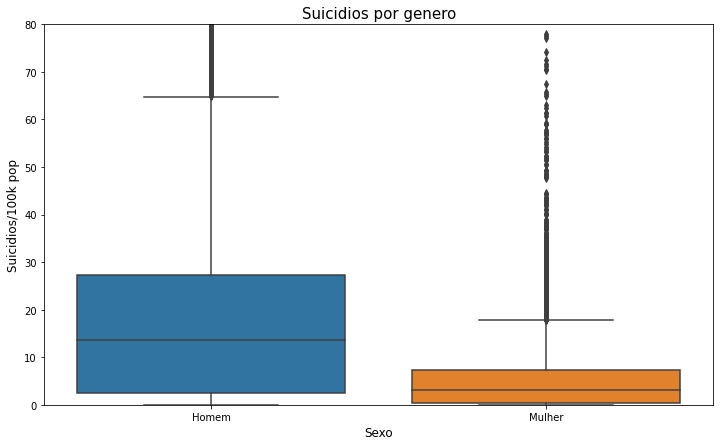

In [ ]:
ax = sns.boxplot(x = 'sexo',y = 'suicidios/100k pop', data = df)
ax.figure.set_size_inches(12,7)
ax.set_ylim((0,80))

ax.set_xlabel('Sexo',size = 12)
ax.set_ylabel('Suicidios/100k pop',size = 12)
ax.set_title('Suicidios por genero', fontsize = 15)

In [ ]:
for i in df.sexo.unique():
  s = df.query(f'sexo == "{i}"')['suicidios/100k pop']

  if verificar_teste(normaltest(s)[-1]):
    print(f'{i} // H0')
  else:
    print(f'{i} // H1')


Homem // H1
Mulher // H1


In [ ]:
homem = df.query('sexo == "Homem"')['suicidios/100k pop']
mulher = df.query('sexo == "Mulher"')['suicidios/100k pop']

print(len(homem) == len(mulher))
# As amostras de homens e mulher possuem mesmo tamanho

True


In [ ]:
_,p_valor = mannwhitneyu(homem,mulher, alternative = 'two-sided')

if verificar_teste(p_valor):
  print('As amostras possuem medidas iguais')

else:
  _,p_valor = mannwhitneyu(homem,mulher, alternative = 'less')
  teste = verificar_teste(p_valor)

  if teste:
    print('Os homens possuem medidas maiores que as mulheres')
  else:
    print('Os homens possuem medidas menores que as mulheres')

Os homens possuem medidas maiores que as mulheres


***Conclusão: Os homens tendem a se matar mais que as mulheres***